# Brief description of the problem and data

The main goal of this project is to create a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. 
The data consists of three files: 
1. train.csv - 7613 tweets
2. test.csv - 3263 tweets
3. sample_submission.csv.

Train and test sets have the following columns:

1. id
2. keyword - a keyword from the tweet (can be blank)
3. location - the location the tweet was sent from (can be blank)
4. text - text of a tweet 

Train dataset has also a column "target" - which contains labels that indicates whether the tweet is about disasters (1) or not (0).

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data 

First, we will import necessary libraries and load datasets

In [79]:
# import libraries for linear algebra, data processing and dictionaries
import numpy as np 
import pandas as pd 
from collections import defaultdict
import re

# libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# libraries for NLP preprocessing
import string
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix


# libraries for NN models creation
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

#!pip3 install bert-for-tf2
from bert import bert_tokenization


In [54]:
# load the datasets
train_df = pd.read_csv('nlp-getting-started/train.csv')
test_df = pd.read_csv('nlp-getting-started/test.csv')
submission = pd.read_csv('nlp-getting-started/sample_submission.csv')

### Data inspection and visualization

Check data information, data types and missing values.

We can see that there are missing values in "keyword" and "location" columns both in training and test dataset.

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [53]:
# Obtain the number of disaster and not disaster tweets
disaster = train_df[train_df['target'] == 1].shape[0]
not_disaster = train_df[train_df['target'] == 0].shape[0]
print(f'There are {disaster} disaster tweets and {not_disaster} general tweets in the training dataset')

There are 3271 disaster tweets and 4342 general tweets in the training dataset


We can also compare the number of real disaster tweets and not disaster tweets using the bar plot: 

<BarContainer object of 1 artists>

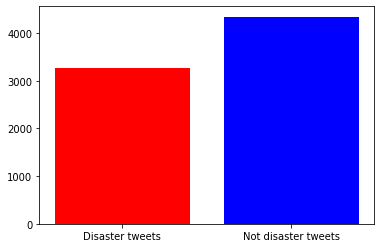

In [8]:
plt.bar('Disaster tweets', disaster, color='red')
plt.bar('Not disaster tweets', not_disaster, color='blue')

In order to visualize the most frequent words we will create corpus by dividing every sentence in a tweet on separate words and adding them to the list and then calculate number of every word using dictionaries.

We will also skip stopwords (a commonly used word such as “the”, “a”, “an”, “in”) when creating the corpus.

In [9]:
# define stopwords 
stop = set(stopwords.words('english'))

In [10]:
# function to create corpus
def create_corpus(df, target='opt'):
    corpus = []
    if target != 'opt':
        for tweet in df[df['target']==target]['text']:
            words = [i for i in word_tokenize(tweet.lower()) if i not in stop]
            corpus.append(words)
    else:
        for tweet in df['text']:
            words = [i for i in word_tokenize(tweet.lower()) if i not in stop]
            corpus.append(words)
    return corpus 
    

Text(0.5, 1.0, 'Most frequent words in general tweets')

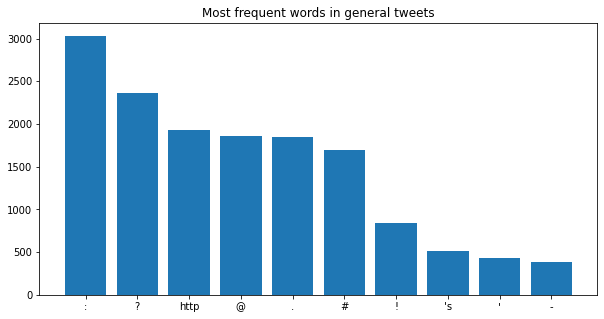

In [55]:
# create dictionary and visualize barplot
dic = defaultdict(int)
for tweet in create_corpus(train_df, 0):
    for word in tweet:
        dic[word] += 1

top = sorted(dic.items(),key=lambda item:item[1], reverse=True)[:10]

plt.figure(figsize=(10,5))
x,y=zip(*top)
plt.bar(x,y)
plt.title('Most frequent words in general tweets')

Text(0.5, 1.0, 'Most frequent words in disaster tweets')

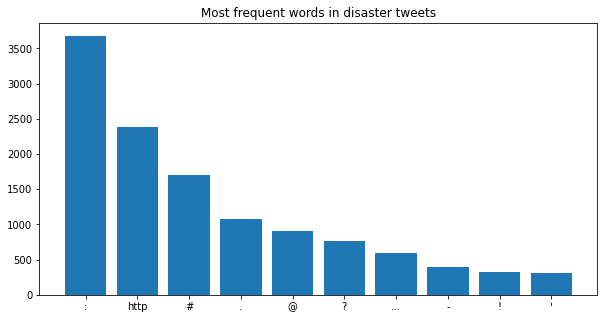

In [56]:
dic = defaultdict(int)
for tweet in create_corpus(train_df, 1):
    for word in tweet:
        dic[word] += 1

top = sorted(dic.items(),key=lambda item:item[1], reverse=True)[:10]

plt.figure(figsize=(10,5))
x,y=zip(*top)
plt.bar(x,y)
plt.title('Most frequent words in disaster tweets')

Although stopwords were removed there are still many unnecessary symbols, such as punctuation symbols. 
Thus, the texts require further cleaning.

### Data cleaning

To clean the tweets, we will crate the function that removes urls, htmls, emojis and punctuations

In [57]:
def cleaning(text):
    text = text.lower()
    url = re.compile(r'https?://\S+|www\.\S+')
    no_url = url.sub(r'', text)
    html = re.compile(r'<.*?>')
    no_html = html.sub(r'', no_url)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    no_emoji = emoji_pattern.sub(r'', no_html)
    cleaned_text = no_emoji.translate(str.maketrans('', '', string.punctuation))
    

    return cleaned_text

In [58]:
train_df['text'] = train_df['text'].apply(lambda x : cleaning(x))
test_df['text'] = test_df['text'].apply(lambda x : cleaning(x))

Now, we can visualize the most frequent words in disaster and not disaster tweets

Text(0.5, 1.0, 'Most frequent words in general tweets')

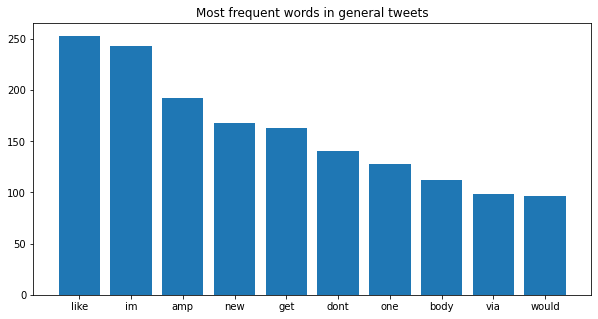

In [61]:
dic_0 = defaultdict(int)
for tweet in create_corpus(train_df, 0):
    for word in tweet:
        dic_0[word] += 1

top = sorted(dic_0.items(),key=lambda item : item[1], reverse=True)[:10]

plt.figure(figsize=(10,5))
x,y=zip(*top)
plt.bar(x,y)
plt.title('Most frequent words in general tweets')

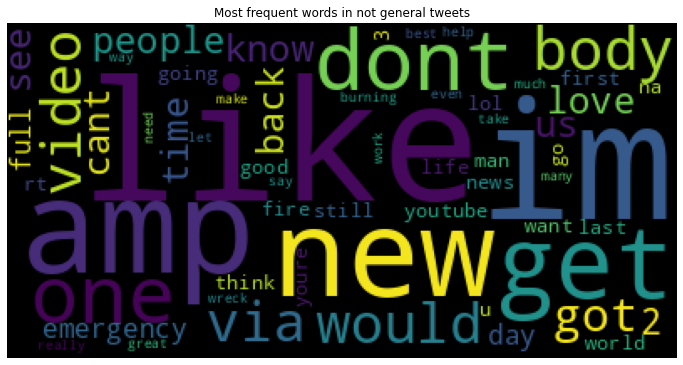

In [62]:
# visualizing the most frequent words using wordcloud
plt.figure(figsize=(12,8))
wc = WordCloud(background_color='black',
               max_words=60,relative_scaling=0.5,
               normalize_plurals=False).generate_from_frequencies(dic_0)
plt.imshow(wc)
plt.axis('off')
plt.title('Most frequent words in not general tweets')
plt.show()

Text(0.5, 1.0, 'Most frequent words in disaster tweets')

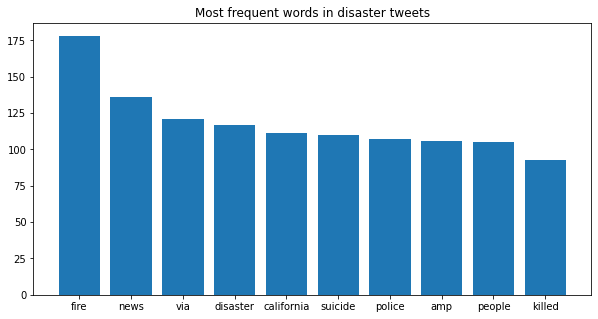

In [63]:
dic_1 = defaultdict(int)
for tweet in create_corpus(train_df, 1):
    for word in tweet:
        dic_1[word] += 1

top = sorted(dic_1.items(),key=lambda item:item[1], reverse=True)[:10]

plt.figure(figsize=(10,5))
x,y=zip(*top)
plt.bar(x,y)
plt.title('Most frequent words in disaster tweets')

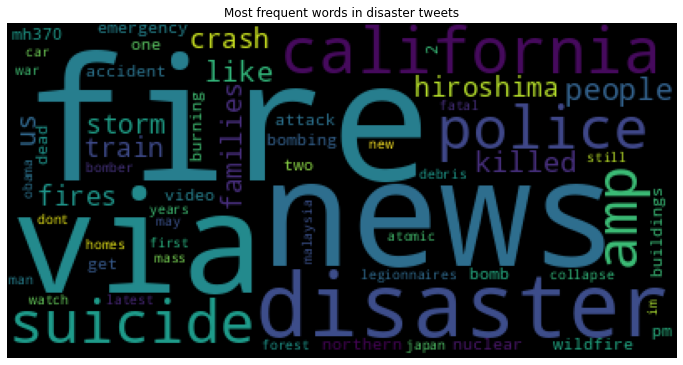

In [64]:
plt.figure(figsize=(12,8))
wc = WordCloud(background_color='black',
               max_words=60,relative_scaling=0.5,
               normalize_plurals=False).generate_from_frequencies(dic_1)
plt.imshow(wc)
plt.axis('off')
plt.title('Most frequent words in disaster tweets')
plt.show()

# Model Architecture

For this competition, we will create and compare 3 models that utilise different embedding techniques:

1. **TF-IDF - Term Frequency-Inverse Document Frequency** - an algorithm based on a statistical measure of finding the relevance of words in the text. 

2. **GloVe - Global Vectors for Word Representation** - an unsupervised learning algorithm that allows to capture the semantic information within a corpus. It focuses on words co-occurrences over the whole corpus and its embeddings relate to the probabilities that two words will appear together.

3. **BERT - Bidirectional Encoder Representations from Transformers** - Bert belongs to the pretrained contextual language representation methods. It is the most advanced of the models that we will use for this project. 

## Simple ANN + TF-IDF
For this model we will use TF-IDF output matrices combined with a simple neural network which contains 4 Dense and 3 Dropout layers.

### Vectorization

In [19]:
list_corpus = train_df['text'].tolist()
list_labels = train_df['target'].tolist()

In [20]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features= 70000)

In [21]:
X_train_tfidf = tfidf_vectorizer.fit_transform(list_corpus).todense()

In [23]:
X_test_tfidf = tfidf_vectorizer.transform(test_df['text']).todense()

In [22]:
X_train_tfidf.shape

(7613, 70000)

In [24]:
# split the training dataset on train and validation parts
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, train_df['target'].values,test_size=0.1)
print('Shape of train',X_train.shape)
print("Shape of validation ",X_val.shape)

Shape of train (6851, 70000)
Shape of validation  (762, 70000)


### Model creation

In [25]:
model_1 = Sequential()

model_1.add(layers.Dense(1024, input_shape= (70000,), activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(1, activation='sigmoid'))


opt = Adam(learning_rate=0.0001)

model_1.compile(loss='binary_crossentropy',optimizer=opt, metrics=['accuracy'])

In [26]:
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              71681024  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [27]:
history_1= model_1.fit(X_train, y_train, validation_data=(X_val,y_val), 
                         batch_size = 64, epochs = 5)


Epoch 1/5
108/108 [==============================] - 24s 217ms/step - loss: 0.6879 - accuracy: 0.5696 - val_loss: 0.6814 - val_accuracy: 0.5472
Epoch 2/5
108/108 [==============================] - 24s 223ms/step - loss: 0.6466 - accuracy: 0.6091 - val_loss: 0.6167 - val_accuracy: 0.6864
Epoch 3/5
108/108 [==============================] - 25s 228ms/step - loss: 0.4734 - accuracy: 0.8375 - val_loss: 0.5087 - val_accuracy: 0.7861
Epoch 4/5
108/108 [==============================] - 24s 226ms/step - loss: 0.2315 - accuracy: 0.9396 - val_loss: 0.5324 - val_accuracy: 0.7822
Epoch 5/5
108/108 [==============================] - 25s 227ms/step - loss: 0.1217 - accuracy: 0.9670 - val_loss: 0.5907 - val_accuracy: 0.7913


In [29]:
predictions_tfidf = model_1.predict(X_test_tfidf, verbose=True)

102/102 [==============================] - 3s 32ms/step


In [30]:
predictions_tfidf = np.where(predictions_tfidf<0.5, 0, 1)
submission['target'] = predictions_tfidf
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [31]:
submission['target'].value_counts()

0    2016
1    1247
Name: target, dtype: int64

In [32]:
submission.to_csv('submission_tfidf.csv', index=False)

## LSTM + GloVe
In the second model we will combine GloVe embeddings with LSTM neural network.

### GloVe embedding

In [36]:
corpus = create_corpus(train_df)

In [37]:
embedding_dict = {}
# Load GloVe 100D embeddings
with open('glove.twitter.27B/glove.twitter.27B.200d.txt','r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word] = vectors
f.close()

In [38]:
# perform tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
train_sequences = tokenizer.texts_to_sequences(corpus)

In [39]:
# pad sequences
train_pad = pad_sequences(train_sequences, maxlen=80, truncating='post', padding='post')

In [40]:
word_index = tokenizer.word_index
print('Number of unique words:',len(word_index))
# load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,200))

for word,i in word_index.items():
    if i < num_words:
        emb_vec = embedding_dict.get(word)
        if emb_vec is not None:
            embedding_matrix[i] = emb_vec 

Number of unique words: 17970


In [47]:
# perform tokenization and padding on test dataset
corpus_test = create_corpus(test_df)
test_sequences = tokenizer.texts_to_sequences(corpus_test)
test_pad = pad_sequences(test_sequences, maxlen=80, truncating='post', padding='post')

In [69]:
# split the training dataset on train and validation parts
X_train, X_val, y_train, y_val = train_test_split(train_pad, train_df['target'].values,test_size=0.1)
print('Shape of train',X_train.shape)
print("Shape of validation ",X_val.shape)

Shape of train (6851, 80)
Shape of validation  (762, 80)


### Model creation

The model contains several layers:
1. Embedding layes
2. SpatialDropout1D - regularization layer, performs the same function as Dropout, however it drops entire 1D feature maps instead of individual elements.
3. LSTM layer - learns long-term dependencies between time steps in sequence data.
4. Dense layer with relu activation function
5. Dropout layer
6. Output Dense layer with sigmoid activation function

In [72]:
model_2 = Sequential()

embedding = layers.Embedding(num_words,200,embeddings_initializer=Constant(embedding_matrix),
                   input_length=80,trainable=True)

model_2.add(embedding)
model_2.add(layers.SpatialDropout1D(0.2))
model_2.add(layers.LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model_2.add(layers.Dense(128,activation = 'relu'))
model_1.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))


opt = Adam(learning_rate=0.0001)

model_2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

### Hyperparameter tuning

We compared different values for hyperparameters for this model:
1. Number of LSTM and Dense layers. Increasing the number doesn't affect performance.
2. Learning rate  The optimal learning rate for this model is 0.0001. 
3. Number of epochs. Model starts to overfit very quickly so the reasonable number of epochs is 5.

In [73]:
history_2 = model_2.fit(X_train, y_train, batch_size=64, epochs=5, validation_data=(X_val,y_val), verbose=True)

Epoch 1/5
108/108 [==============================] - 23s 202ms/step - loss: 0.6861 - accuracy: 0.5710 - val_loss: 0.6854 - val_accuracy: 0.5617
Epoch 2/5
108/108 [==============================] - 23s 210ms/step - loss: 0.6138 - accuracy: 0.6609 - val_loss: 0.4727 - val_accuracy: 0.8110
Epoch 3/5
108/108 [==============================] - 22s 200ms/step - loss: 0.4838 - accuracy: 0.7876 - val_loss: 0.4747 - val_accuracy: 0.8031
Epoch 4/5
108/108 [==============================] - 21s 197ms/step - loss: 0.4500 - accuracy: 0.8100 - val_loss: 0.4466 - val_accuracy: 0.8123
Epoch 5/5
108/108 [==============================] - 22s 200ms/step - loss: 0.4310 - accuracy: 0.8171 - val_loss: 0.4457 - val_accuracy: 0.8097


In [48]:
predictions_glove = model_2.predict(test_pad, verbose=True)
predictions_glove = np.where(predictions_glove<0.5, 0, 1)
submission['target'] = predictions_glove
submission.to_csv('submission_glove.csv', index=False)

102/102 [==============================] - 2s 20ms/step


## BERT pretrained model 

For this model, we will load pretrained BERT model and BERT tokenizer. 

In [84]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)

### BERT embedding

BERT is a pretrained model so we need to prepare our input data:

- A special token, [SEP], to mark the end of a sentence, or the separation between two sentences
- A special token, [CLS], at the beginning of our text.
- Tokens that conform with the fixed vocabulary used in BERT
- The Token IDs for the tokens, from BERT’s tokenizer
- Mask IDs to indicate which elements in the sequence are tokens and which are padding elements
- Segment IDs used to distinguish different sentences
- Positional Embeddings used to show token position within the sequence

The recommended learning rate for the BERT model is 0.0000 (2e-5)


In [85]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

### Model creation

In [86]:
max_len = 80
input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
clf_output = sequence_output[:, 0, :]
    
layer = tf.keras.layers.Dense(64, activation='relu')(clf_output)
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Dense(32, activation='relu')(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
out = tf.keras.layers.Dense(1, activation='sigmoid')(layer)
    
model_3 = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
model_3.compile(tf.keras.optimizers.Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
  

In [87]:
train_input = bert_encode(train_df['text'].values, tokenizer, max_len=max_len)
test_input = bert_encode(test_df['text'].values, tokenizer, max_len=max_len)
train_labels = train_df['target'].values

In [88]:

model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 80)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 80)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 80)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 80, 768)]                 'input_mask[0][0]',         

In [89]:
history = model_3.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=64,
    verbose=1
)

Epoch 1/3
96/96 [==============================] - 1532s 16s/step - loss: 0.4846 - accuracy: 0.7826 - val_loss: 0.3912 - val_accuracy: 0.8345
Epoch 2/3
96/96 [==============================] - 1461s 15s/step - loss: 0.3777 - accuracy: 0.8542 - val_loss: 0.4273 - val_accuracy: 0.8267
Epoch 3/3
96/96 [==============================] - 1459s 15s/step - loss: 0.3154 - accuracy: 0.8816 - val_loss: 0.4181 - val_accuracy: 0.8339


In [90]:
predictions_bert = model_3.predict(test_input, verbose=True)
predictions_bert = np.where(predictions_bert<0.5, 0, 1)
submission['target'] = predictions_bert
submission.to_csv('submission_bert.csv', index=False)

102/102 [==============================] - 227s 2s/step


# Results and Analysis

## Learning curves

###  TF-IDF + simple ANN

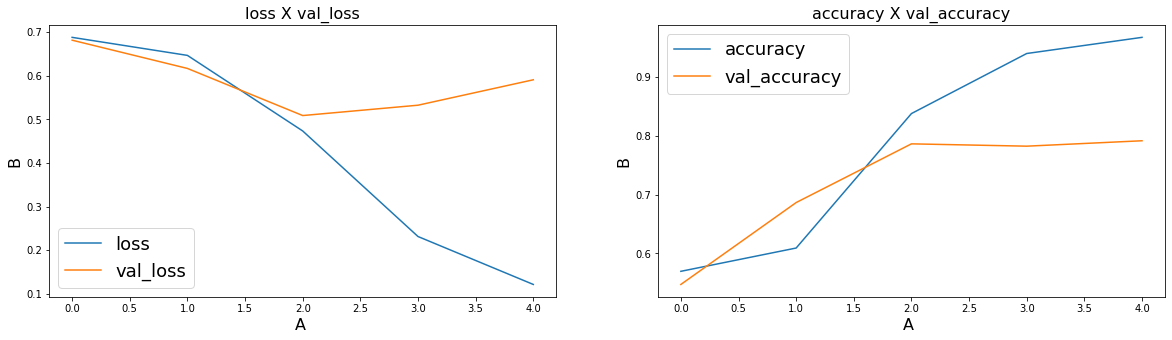

In [81]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

plot_learning_curves(history_1, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

### GloVe + LSTM

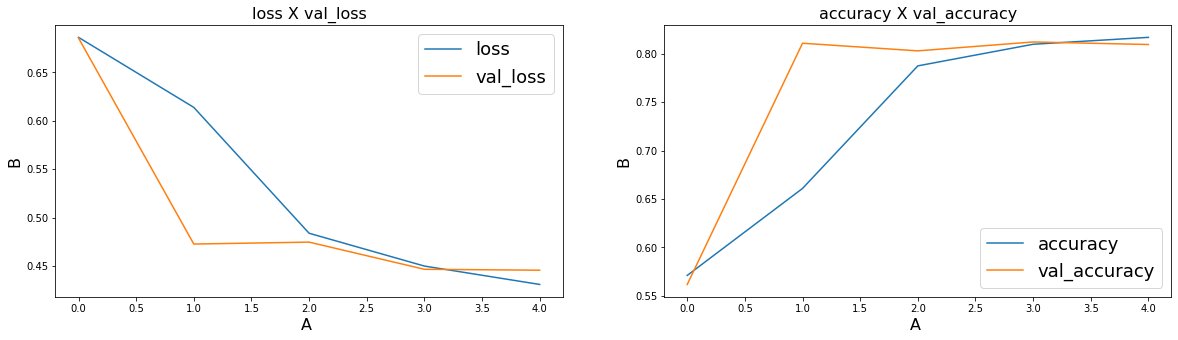

In [83]:
plot_learning_curves(history_2, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

### BERT

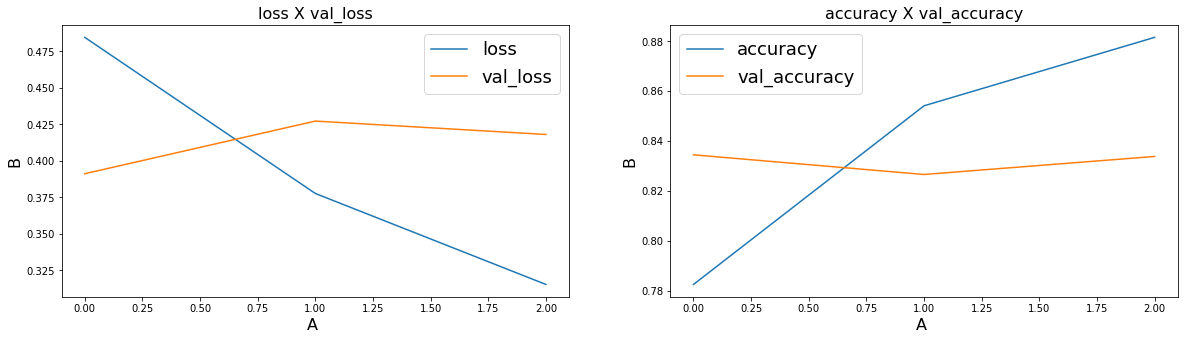

In [91]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

## Confusion matrices

### TF-IDF + simple ANN

In [33]:
y_train_predict = model_1.predict(X_train, verbose=True)
y_train_predict = np.where(y_train_predict<0.5, 0, 1)
y_val_predict = model_1.predict(X_val, verbose=True)
y_val_predict = np.where(y_val_predict<0.5, 0, 1)

24/24 [==============================] - 1s 33ms/step


In [34]:
unique, counts = np.unique(y_train_predict, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 3972]
 [   1 2879]]


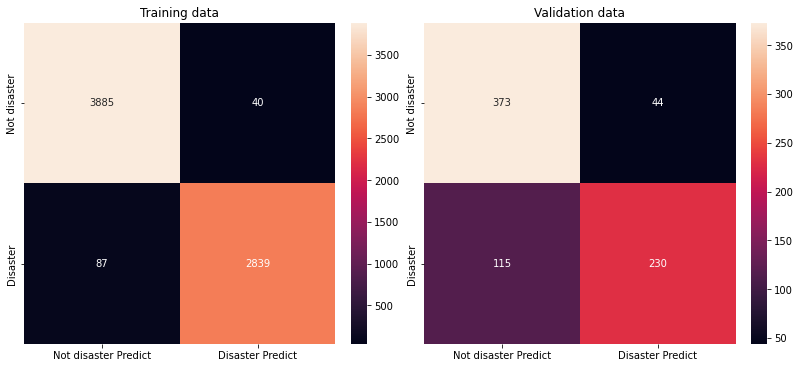

In [35]:
cm = confusion_matrix(y_train, y_train_predict, labels=[0, 1])
df_cm = pd.DataFrame(cm, index = ['Not disaster','Disaster'],
                  columns = ['Not disaster Predict','Disaster Predict'])
cmt = confusion_matrix(y_val, y_val_predict, labels=[0, 1])
df_cmt = pd.DataFrame(cmt, index = ['Not disaster','Disaster'],
                  columns = ['Not disaster Predict','Disaster Predict'])
fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(11,5))
ax[0].set_title('Training data')
ax[1].set_title('Validation data')
sns.heatmap(df_cm, annot=True, fmt='g', ax=ax[0])
sns.heatmap(df_cmt, annot=True, fmt='g',ax=ax[1])
plt.show()

### GloVe + LSTM

In [50]:
y_train_predict = model_2.predict(X_train, verbose=True)
y_train_predict = np.where(y_train_predict<0.5, 0, 1)
y_val_predict = model_2.predict(X_val, verbose=True)
y_val_predict = np.where(y_val_predict<0.5, 0, 1)

24/24 [==============================] - 0s 20ms/step


In [51]:
unique, counts = np.unique(y_train_predict, return_counts=True)

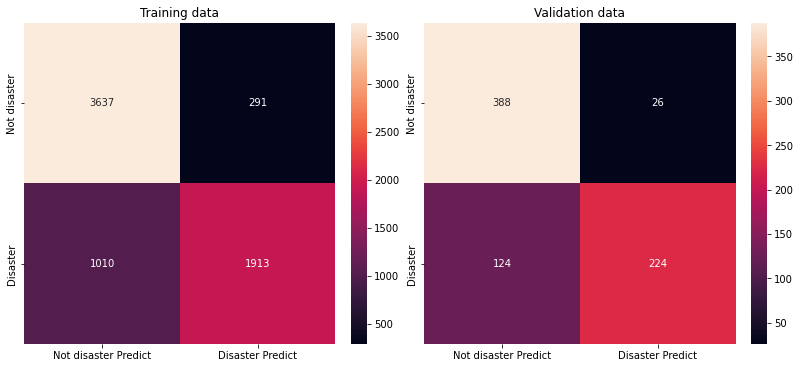

In [52]:
cm = confusion_matrix(y_train, y_train_predict, labels=[0, 1])
df_cm = pd.DataFrame(cm, index = ['Not disaster','Disaster'],
                  columns = ['Not disaster Predict','Disaster Predict'])
cmt = confusion_matrix(y_val, y_val_predict, labels=[0, 1])
df_cmt = pd.DataFrame(cmt, index = ['Not disaster','Disaster'],
                  columns = ['Not disaster Predict','Disaster Predict'])
fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(11,5))
ax[0].set_title('Training data')
ax[1].set_title('Validation data')
sns.heatmap(df_cm, annot=True, fmt='g', ax=ax[0])
sns.heatmap(df_cmt, annot=True, fmt='g',ax=ax[1])
plt.show()

### BERT

In [ ]:
y_train_predict = model_3.predict(train_input, verbose=True)
y_train_predict = np.where(y_train_predict<0.5, 0, 1)

In [103]:
y_train = np.array(train_df['target'])

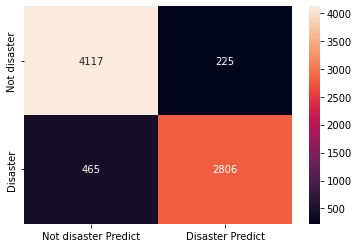

In [104]:
cm = confusion_matrix(y_train, y_train_predict, labels=[0, 1])
df_cm = pd.DataFrame(cm, index = ['Not disaster','Disaster'],
                  columns = ['Not disaster Predict','Disaster Predict'])

sns.heatmap(df_cm, annot=True, fmt='g')
plt.show()

# Conclusion

For this NLP project, we have built and compared three models with different embedding techniques. 
Surprisingly, the performance of GloVe model was worse than of basic network with TF-IDF. The reason can be in an increased ‘noisiness’ of signal in GloVe embedding (which is a much more complex word representation) compared to TF-IDF. 
As expected, the best results were obtained with the BERT model.

All models have tendency to overfitting after 3 epochs approx.

To further improve the performance we can also pay more attention to data cleaning and preparation or use advansed pretrained models (such as XLM-RoBERTa etc)

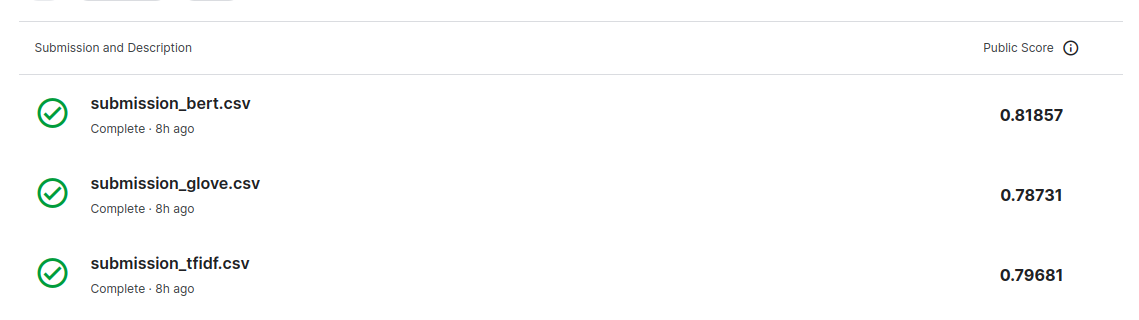